/home/cqilab/anaconda3/envs/ditto/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
/home/cqilab/anaconda3/envs/ditto/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


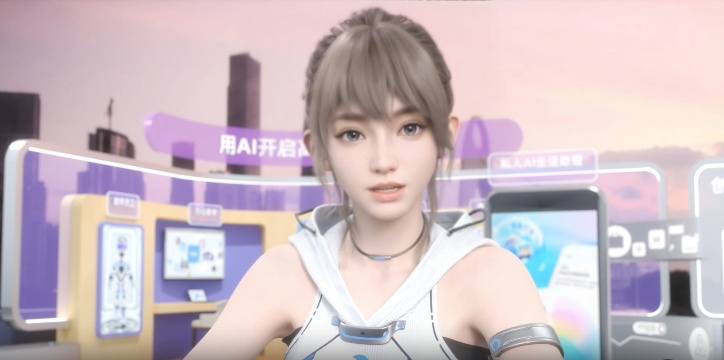

KeyboardInterrupt: 

In [ ]:
from fractions import Fraction
import queue, threading, time, uuid, math, asyncio, os, subprocess, io
import numpy as np
import librosa
import soundfile as sf
from IPython.display import display, update_display, Image as IPyImage
from stream_pipeline_online import StreamSDK
from kokoro import KPipeline  # make sure KokoroTTS is available

# --- paths (change these) ---
CFG_PKL  = "./checkpoints/ditto_cfg/v0.4_hubert_cfg_trt.pkl"
DATA_ROOT = "./checkpoints/ditto_trt_Ampere_Plus"
SOURCE_PATH = "static/avatar.png" 
GENERATED_AUDIO = "static/generated.wav"

# --- prompt for speech generation ---
prompt = """Yes, I came here five years ago, when I was just sixteen. At the time, I was.. I was still in the tenth grade, and I clearly remember doing my homework in the backseat of the car as we drove to our new home. Everything felt unfamiliar and uncertain, but I tried to stay focused on school. I didn’t know what to expect, and it took a while to get used to the language, the people, and the new routines. I had to figure things out quickly—how to fit in, how to keep up with assignments, how to not fall behind. There were moments I felt out of place, but I kept.. I kept going. Looking back, it was, was one of the hardest transitions I’ve experienced, but it also taught me how to adapt, how to be more independent, and.. and how to push through when things felt overwhelming."""

# --- generate audio using KokoroTTS ---
pipeline = KPipeline(lang_code="a")

# --- initialize SDK ---
sdk = StreamSDK(CFG_PKL, DATA_ROOT, chunk_size=(3,5,2))
sdk.online_mode = True
sdk.setup(SOURCE_PATH)

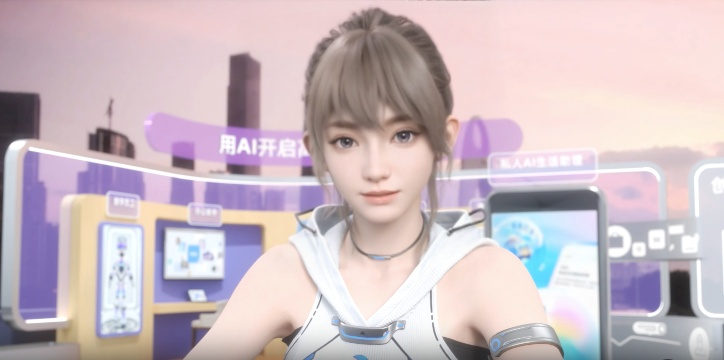

In [ ]:
for _, _, audio in pipeline(prompt, voice="af_heart", speed=1.1):
    sf.write(GENERATED_AUDIO, audio, 24000)
    break

# --- load audio at 16kHz for StreamSDK ---
audio, _ = librosa.load(GENERATED_AUDIO, sr=24000)
sdk.start_processing_audio()


def stream_and_preview(max_fps: float = 26.7):
    BYTES_PER_FRAME = 640
    present = sdk.chunk_size[1] * BYTES_PER_FRAME
    split_len = int(sum(sdk.chunk_size) * BYTES_PER_FRAME) + 80
    start = 0
    while start < len(audio):
        chunk = audio[start : start + split_len]
        if len(chunk) < split_len:
            chunk = np.pad(chunk, (0, split_len - len(chunk)), mode='constant')
        sdk.process_audio_chunk(chunk)
        start += present

    sdk.end_processing_audio()

    # frame_interval = 1.0 / max_fps
    frame_interval = 1.0 / (max_fps)
    last = time.time()
    handle_id = str(uuid.uuid4()) 
    display_started = False
    while True:
        if not sdk.has_pending_frames() and sdk.frame_queue.qsize() == 0:
            break
        try:
            jpg_bytes, fid, gid = sdk.frame_queue.get(timeout=0.1)
        except queue.Empty:
            continue  # wait for next frame

        img_obj = IPyImage(data=jpg_bytes)
        if not display_started:
            display(img_obj, display_id=handle_id)
            display_started = True
        else:
            update_display(img_obj, display_id=handle_id)

        delta = time.time() - last
        if delta < frame_interval:
            time.sleep(frame_interval - delta)
        last = time.time()
    sdk.close()

    
stream_and_preview()

In [ ]:
import threading, time, uuid, io, numpy as np
from IPython.display import display, update_display, Image as IPyImage
from stream_pipeline_online import StreamSDK
from kokoro import KPipeline
import queue, threading, time, uuid, math, asyncio, os, subprocess, io
from IPython.display import Audio


# --- config ---
CFG_PKL  = "./checkpoints/ditto_cfg/v0.4_hubert_cfg_trt.pkl"
DATA_ROOT = "./checkpoints/ditto_trt_Ampere_Plus"
SOURCE_PATH = "static/avatar.png"
prompt = """Yes, I came here five years ago, when I was just sixteen. At the time, I was.. I was still in the tenth grade, and I clearly remember doing my homework in the backseat of the car as we drove to our new home. Everything felt unfamiliar and uncertain, but I tried to stay focused on school. I didn’t know what to expect, and it took a while to get used to the language, the people, and the new routines. I had to figure things out quickly—how to fit in, how to keep up with assignments, how to not fall behind. There were moments I felt out of place, but I kept.. I kept going. Looking back, it was, was one of the hardest transitions I’ve experienced, but it also taught me how to adapt, how to be more independent, and.. and how to push through when things felt overwhelming."""

# --- generate audio directly in memory (no disk IO) ---
pipeline = KPipeline(lang_code="a")
for _, _, audio_np in pipeline(prompt, voice="af_heart", speed=1.1):
    break

# --- initialize SDK ---
sdk = StreamSDK(CFG_PKL, DATA_ROOT, chunk_size=(3,5,2))
sdk.online_mode = True
sdk.setup(SOURCE_PATH)
sdk.start_processing_audio()

# --- feed audio chunks in parallel ---
def feed_audio():
    BYTES_PER_FRAME = 640
    present = sdk.chunk_size[1] * BYTES_PER_FRAME
    split_len = int(sum(sdk.chunk_size) * BYTES_PER_FRAME) + 80
    start = 0
    while start < len(audio_np):
        chunk = audio_np[start : start + split_len]
        if len(chunk) < split_len:
            chunk = np.pad(chunk, (0, split_len - len(chunk)), mode='constant')
        sdk.process_audio_chunk(chunk)
        start += present
    sdk.end_processing_audio()

audio_thread = threading.Thread(target=feed_audio)
audio_thread.start()

# --- preview in parallel (fast refresh loop) ---
def preview_loop(max_fps: float = 26.7):
    handle_id = str(uuid.uuid4())
    display_started = False
    interval = 1.0 / max_fps
    last = time.time()

    while True:
        if not sdk.has_pending_frames() and sdk.frame_queue.qsize() == 0:
            break
        try:
            jpg_bytes, _, _ = sdk.frame_queue.get(timeout=0.01)
        except queue.Empty:
            continue
        img = IPyImage(data=jpg_bytes)
        if not display_started:
            display(img, display_id=handle_id)
            display_started = True
        else:
            update_display(img, display_id=handle_id)

        delta = time.time() - last
        if delta < interval:
            time.sleep(interval - delta)
        last = time.time()

    sdk.close()

# --- idle audio generator (silence) ---
def generate_silence_audio(duration_sec=10.0, sample_rate=16000):
    samples = int(duration_sec * sample_rate)
    return np.zeros(samples, dtype=np.float32)

# --- feed audio chunks (shared for silence and actual audio) ---
def feed_audio(audio_array):
    BYTES_PER_FRAME = 640
    present = sdk.chunk_size[1] * BYTES_PER_FRAME
    split_len = int(sum(sdk.chunk_size) * BYTES_PER_FRAME) + 80

    start = 0
    while start < len(audio_array):
        chunk = audio_array[start : start + split_len]
        if len(chunk) < split_len:
            chunk = np.pad(chunk, (0, split_len - len(chunk)), mode='constant')
        sdk.process_audio_chunk(chunk)
        start += present
    sdk.end_processing_audio()

# --- idle loop: keep feeding silence until interrupted ---
def idle_loop():
    while True:
        if not idle_active_event.is_set():
            time.sleep(0.1)
            continue
        sdk.start_processing_audio()
        feed_audio(generate_silence_audio(13))  # 3 seconds of silence
        time.sleep(0.5)

# --- preview stream ---
def preview_loop(max_fps: float = 26.7):
    handle_id = str(uuid.uuid4())
    display_started = False
    interval = 1.0 / max_fps
    last = time.time()

    while True:
        try:
            if not sdk.has_pending_frames() and sdk.frame_queue.qsize() == 0:
                time.sleep(0.01)
                continue
            jpg_bytes, _, _ = sdk.frame_queue.get(timeout=0.01)
            img = IPyImage(data=jpg_bytes)
            if not display_started:
                display(img, display_id=handle_id)
                display_started = True
            else:
                update_display(img, display_id=handle_id)
        except queue.Empty:
            continue

        delta = time.time() - last
        if delta < interval:
            time.sleep(interval - delta)
        last = time.time()

# --- play actual audio and resume idle ---
def play_prompt(prompt_text):
    idle_active_event.clear()
    sdk.start_processing_audio()

    # Get audio
    for _, _, real_audio in pipeline(prompt_text, voice="af_heart", speed=1.1):
        break
    feed_audio(real_audio)

    idle_active_event.set()

# --- initialize and start ---

idle_active_event = threading.Event()
idle_active_event.set()

threading.Thread(target=idle_loop, daemon=True).start()
threading.Thread(target=preview_loop, daemon=True).start()

idle_active_event.clear()
sdk.close()


KeyboardInterrupt: 

In [3]:
import librosa
import soundfile as sf
import numpy as np

# Load original MP3
y, sr = librosa.load("audio.mp3", sr=16000)

# Generate 2 seconds of silence
silence = np.zeros(int(sr * 1.7), dtype=np.float32)

# Option 1: prepend silence
y_silenced = np.concatenate((silence, y))

# Option 2: append silence instead
# y_silenced = np.concatenate((y, silence))

# Save to new file (e.g. WAV to preserve quality)
sf.write("/DISK/LLM-Finetune/DittoLive/static/audio_with_silence_1.7s.wav", y_silenced, sr)
